# Logistic Regression for Sentiment Classification


As a first evaluation of classification power for the task of shallow models we used Logistic Regression.

Using Code from https://www.kaggle.com/dehaozhang/sentiment-analysis-with-lr

In [1]:
# Imports

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from nltk.stem import PorterStemmer

# Load and Inspect

In [2]:
train_data = pd.read_csv("./data/train.tsv", sep='\t')

In [3]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [5]:
train_data.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [6]:
for sen in train_data.Phrase[0:2]:
    print(sen)

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
A series of escapades demonstrating the adage that what is good for the goose


In [7]:
# Only Phrase and Sentiment Relevant

train_df = train_data[['Phrase', 'Sentiment']]
train_df.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


## Sentiment Distribution

In [11]:
sorted_sentiments = (train_df.Sentiment.value_counts()).sort_index()
sorted_sentiments
sorted_sentiments.values

array([ 7072, 27273, 79582, 32927,  9206], dtype=int64)

Text(0.5, 0, 'Rating')

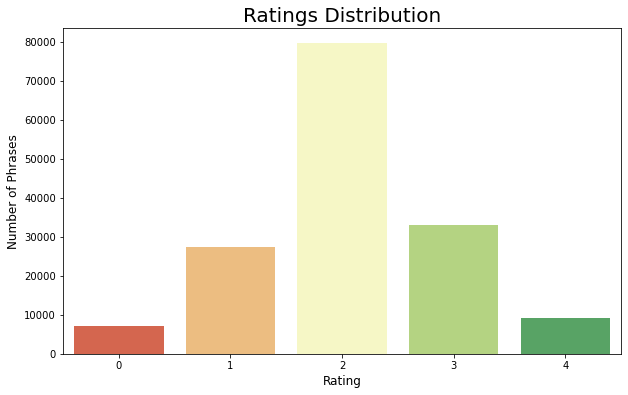

In [19]:
sns.color_palette("viridis", as_cmap=True)

fig = plt.figure(figsize=(10, 6))

ax = sns.barplot(sorted_sentiments.index, sorted_sentiments.values, palette=sns.color_palette("RdYlGn",5))
plt.title("Ratings Distribution",fontsize = 20)
plt.ylabel('Number of Phrases', fontsize = 12)
plt.xlabel('Rating', fontsize = 12)

# Train Test Split

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_df, test_size = 0.3, stratify = train_df['Sentiment'], random_state = 42)

In [11]:
train.shape, test.shape

((109242, 2), (46818, 2))

## Building The Feature Set

And the Vocabulary

In [12]:
c_vectorizer = CountVectorizer(max_df=0.95, min_df=10)
c_vectorizer.fit_transform(train_df['Phrase'].values)

train_feature_set = c_vectorizer.transform(train['Phrase'].values)
test_feature_set = c_vectorizer.transform(test['Phrase'].values)

In [13]:
train_feature_set.shape

(109242, 10862)

In [14]:
test_feature_set.shape

(46818, 10862)

In [15]:
# mapping of the vocabulary
c_vectorizer.vocabulary_['deceit']

2416

In [16]:
# Return first 5 Vocabulary Mappings
from itertools import islice
list(islice( c_vectorizer.vocabulary_.items(), 5))

[('series', 8460),
 ('of', 6596),
 ('demonstrating', 2510),
 ('the', 9662),
 ('adage', 219)]

## Model Training

### Logistic Regression

In [17]:
start_time = time.time()

y_train = train['Sentiment'].values
y_test = test['Sentiment'].values

lr = LogisticRegression(solver='saga', random_state=42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)

print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to train model and make predictions:  0.11  mins


## Evalution

In [18]:
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred, average='weighted'),3))

Accuracy:  0.644
F1:  0.623


C:\Users\Jan Decker\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


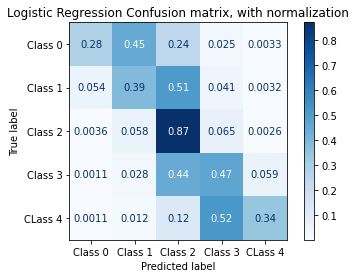

In [19]:
disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'CLass 4'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

### Feature Insights

In [20]:
feature_importance = lr.coef_[0][:10]
for i,v in enumerate(feature_importance):
    print('Feature: ', list(c_vectorizer.vocabulary_.keys())[list(c_vectorizer.vocabulary_.values()).index(i)], 'Score: ', v)

Feature:  000 Score:  0.4690659225062045
Feature:  10 Score:  0.4006591666929058
Feature:  100 Score:  -0.4314412744959059
Feature:  101 Score:  0.6123341205037955
Feature:  102 Score:  0.018013780445061484
Feature:  103 Score:  -0.04829192760625129
Feature:  104 Score:  0.4079781865472685
Feature:  105 Score:  0.4580726427477171
Feature:  10th Score:  -0.06677890281481554
Feature:  11 Score:  0.021564366663680393


In [21]:
feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)
top_10_pos_w = [list(c_vectorizer.vocabulary_.keys())[list(c_vectorizer.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_w)

['worst', 'waste', 'failure', 'disappointment', 'distasteful', 'mess', 'unappealing', 'lame', 'awful', 'stupid']


C:\Users\Jan Decker\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


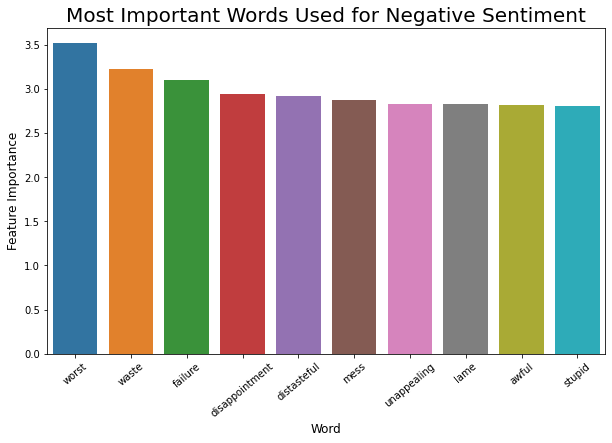

In [22]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_pos_w, feature_importance[sorted_idx[range(-1,-11, -1)]])
plt.title("Most Important Words Used for Negative Sentiment",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

In [23]:
top_10_neg_w = [list(c_vectorizer.vocabulary_.keys())[list(c_vectorizer.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
print(top_10_neg_w)

['remarkable', 'hilarious', 'giving', 'although', 'fascinating', 'courage', 'quirky', 'giddy', 'gorgeous', 'sweet']


C:\Users\Jan Decker\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


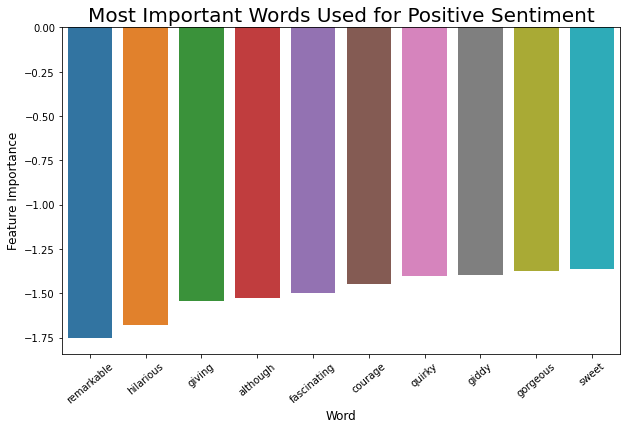

In [24]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_neg_w, feature_importance[sorted_idx[:10]])
plt.title("Most Important Words Used for Positive Sentiment",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

In [25]:
lr.classes_

array([0, 1, 2, 3, 4], dtype=int64)

In [26]:
test_sentence = c_vectorizer.transform(['An intermittently pleasing but mostly routine effort .'])
lr.predict_proba(test_sentence)

array([[0.00074762, 0.05291066, 0.3311994 , 0.61041742, 0.00472489]])

In [27]:
lr.predict(test_sentence)

array([3], dtype=int64)